In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import math
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
from tqdm import tqdm

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.model.mpra_basset import MPRA_Basset
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print('')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode



In [3]:
# with open('BODA_asiSI_sequences.txt', 'r') as f:
#     lines = f.readlines()
    
# sequence_IDs = []
# for line in lines:
#     sequence_IDs.append(line.split()[1])
# sequence_IDs = [sequence_ID for sequence_ID in sequence_IDs if ('dhs' not in sequence_ID) and ('gw' not in sequence_ID)]
    
# fasta_file_name = 'boda_design__round_1__20211214.fa'
# fasta_dict = {}
# with open(fasta_file_name, 'r') as f:
#     for line in f:
#         line_str = str(line)
#         if line_str[0] == '>':
#             my_id = line_str.lstrip('>').rstrip('\n')
#             fasta_dict[my_id] = ''
#         else:
#             fasta_dict[my_id] += line_str.rstrip('\n')
            
# sequences = []
# for sequence_ID in sequence_IDs:
#     sequences.append(fasta_dict[sequence_ID])


#Sagers:
#Sagers
    
fasta_file_name = 'asiSI_hits__20211215.fa'
fasta_dict = {}
with open(fasta_file_name, 'r') as f:
    for line in f:
        line_str = str(line)
        if line_str[0] == '>':
            my_id = line_str.lstrip('>').rstrip('\n')
            fasta_dict[my_id] = ''
        else:
            fasta_dict[my_id] += line_str.rstrip('\n')
            
sequence_IDs = list(fasta_dict.keys())
sequences = list(fasta_dict.values())

In [4]:
def fasta_to_input_tensor(file_name, left_flank, right_flank):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    sequences = torch.stack(seq_tensors, dim=0)
    pieces = [left_flank.repeat(sequences.shape[0], 1, 1), sequences,  right_flank.repeat(sequences.shape[0], 1, 1)]
    return torch.cat(pieces, axis=-1)

In [5]:
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200]).unsqueeze(0)   

In [6]:
onehot_sequences = torch.stack([utils.dna2tensor(sequence) for sequence in sequences])
pieces = [left_flank.repeat(onehot_sequences.shape[0], 1, 1), onehot_sequences, right_flank.repeat(onehot_sequences.shape[0], 1, 1)]
input_tensor_1 = torch.cat( pieces, axis=-1)

#input_tensor_2 = fasta_to_input_tensor('BODA_asiSI_synth_sequences_alt.txt', left_flank, right_flank)

#Sagers:
input_tensor_2 = fasta_to_input_tensor('asiSI_hits__20211215_alt.fa', left_flank, right_flank)

In [7]:
preds_1 = model(input_tensor_1.cuda()).detach().cpu()
preds_2 = model(input_tensor_2.cuda()).detach().cpu()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
import scipy.stats as stats

def get_scatterplots(truths_array, preds_array, specificity_fn, celltypes=['K562', 'HepG2', 'SKNSH']):
    fig = plt.figure(figsize=(25,6))
    pearsons = []
    spearmans = []
    num_figures = len(celltypes) + 1 
    for dim in range(num_figures - 1):
        plt.subplot(1, num_figures, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim), alpha=0.8)
        plt.xlabel('Original l2fc')
        plt.ylabel('Modified l2fc')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        #plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
        plt.title(f'{celltypes[dim]}')#' | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.subplot(1, num_figures, num_figures)
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6', alpha=0.8)
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('Original')
    plt.ylabel('Modified')
    #plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    plt.title(f'Entropy')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(spearmans), 2)}')
    print('----------------------------------------------')
    
def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return shannon 


----------------------------------------------
Pearsons: [0.9974726544072968, 0.9983858525646496, 0.9978356194542346], average: 1.0
Spearmans: [0.9953318874815574, 0.9961947850795981, 0.9949417583313401], average: 1.0
----------------------------------------------


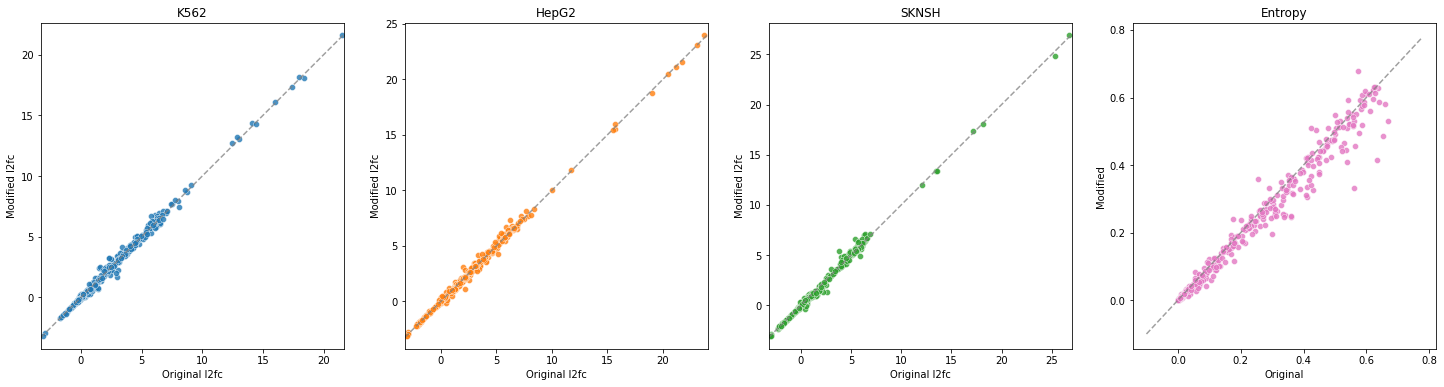

In [9]:
get_scatterplots(preds_1.numpy(), preds_2.numpy(), specificity_fn=entropy)